In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
rna_sequnce = ['ACT','GTU' , 'AUN']

In [4]:
def encode_seq(kmer_token):

    # A 1 0 0 0
    # C 0 1 0 0
    # T/U 0 0 0 1
    # G 0 0 1 0
    # N 0 0 0 0

    encoding_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [0, 0, 0, 1],
        'N': [0, 0, 0, 0],
    }

    encoded_sequence = []
    for  base in kmer_token:
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).flatten()

x = []
for seq in rna_sequnce:
    x.append(encode_seq(seq))
x = torch.from_numpy( np.array(x))
x

tensor([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=torch.int32)

In [5]:
labels = ['red','blue','green']
le = LabelEncoder()
y = le.fit_transform(labels)
y = torch.from_numpy(np.array(y))
y 

tensor([2, 0, 1])

# Single Directional LSTM

In [6]:
hidden_dim = 3
embedding_dim = 7
input_dim = 12

embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True )
fc = nn.Linear(hidden_dim, 3) 

In [7]:
embedding_out =  embedding(x)
print(embedding_out.shape)

torch.Size([3, 12, 7])


In [8]:
lstm_out , (h,c) = lstm(embedding_out)

print(h.shape)
h[-1] # In case of Bi Directional use both output

torch.Size([1, 3, 3])


tensor([[-0.3182, -0.3496, -0.1638],
        [-0.3374, -0.3485, -0.1835],
        [ 0.0110, -0.3792, -0.0650]], grad_fn=<SelectBackward0>)

In [9]:
outputs = fc(h[-1])
outputs

tensor([[ 0.0579, -0.2409,  0.3592],
        [ 0.0663, -0.2351,  0.3612],
        [ 0.0163, -0.3359,  0.3352]], grad_fn=<AddmmBackward0>)

In [10]:

_, predicted = torch.max(outputs,1)
predicted

tensor([2, 2, 2])

In [11]:
loss_function = nn.CrossEntropyLoss()
loss = loss_function(outputs, y)
loss.item()

1.1434829235076904

# Bi-Directional LSTM with Attention

In [12]:
hidden_dim = 3
embedding_dim = 7
input_dim = 12

b_embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
b_lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True , bidirectional=True )
b_fc = nn.Linear(2*hidden_dim, 3) 

In [13]:
b_embedding_out =  embedding(x)
print(b_embedding_out.shape)

torch.Size([3, 12, 7])


In [14]:
b_lstm_out , (h,c) = lstm(embedding_out)

#       [[[ 0.1242,  0.0155,  0.1971],
#          [ 0.1305,  0.0160,  0.2074],
#          [ 0.1432, -0.0180, -0.1529]],

#         [[ 0.0721, -0.3585, -0.2495],
#          [-0.0041, -0.4517, -0.1265],
#          [ 0.0710, -0.3557, -0.2356]]]

b_h = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
b_h

IndexError: index -2 is out of bounds for dimension 0 with size 1

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1)
        hidden = hidden.expand(-1, encoder_outputs.size(1), -1)
        # Aboe two steps makes hidden dim similar to encoder_outputs
        
        alignment_scores = self.v(torch.tanh(self.W(hidden + encoder_outputs)))
        attention_weights = F.softmax(alignment_scores, dim=1)
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=1)
        return context_vector, attention_weights

In [ ]:
attention = BahdanauAttention(2*hidden_dim)
context_vector , weights = attention(b_h , b_lstm_out)
context_vector

tensor([[-0.3244,  0.2820, -0.0638,  0.2010, -0.1485,  0.0028],
        [-0.3227,  0.2817, -0.0600,  0.2047, -0.1535, -0.0042],
        [-0.3397,  0.2763, -0.0792,  0.1829, -0.1382,  0.0202]],
       grad_fn=<SumBackward1>)

In [ ]:
outputs = fc(context_vector)
outputs

tensor([[ 0.3206, -0.0334,  0.1136],
        [ 0.3347, -0.0262,  0.1085],
        [ 0.3144, -0.0332,  0.1178]], grad_fn=<AddmmBackward0>)

In [ ]:
_, predicted = torch.max(outputs,1)
predicted

tensor([0, 0, 0])

In [ ]:
loss_function = nn.CrossEntropyLoss()
loss = loss_function(outputs, y)
loss.item()

1.106108546257019

# Mult Task Learning

In [16]:
y

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
input_dim = 4
embedding_dim = 7
input_dim = 12
hidden_dim = 4
NUM_OF_TASK = 13

embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True )
single_fc = nn.Linear(hidden_dim, 1) 
fc = nn.ModuleList([nn.Linear(hidden_dim, 1) for _ in range(NUM_OF_TASK)])

In [18]:
embedding_output = embedding(x)
embedding_output.shape

torch.Size([3, 12, 7])

In [19]:
_ , (h,c) = lstm(embedding_output)

h[-1].squeeze(1)

tensor([[ 0.1572, -0.4448,  0.5386, -0.0013],
        [ 0.1648, -0.4562,  0.5444, -0.0179],
        [ 0.0728, -0.0921,  0.3098,  0.0965]], grad_fn=<SqueezeBackward1>)

In [20]:
single_out = single_fc(h[-1])
single_out.squeeze(1)

tensor([-0.2508, -0.2602, -0.0553], grad_fn=<SqueezeBackward1>)

In [21]:
out = []
for f in fc:
    out.append(f(h[-1]).squeeze(1)) 
out

[tensor([-0.1598, -0.1599,  0.0322], grad_fn=<SqueezeBackward1>),
 tensor([-0.4146, -0.4106, -0.3611], grad_fn=<SqueezeBackward1>),
 tensor([-0.0508, -0.0419, -0.2444], grad_fn=<SqueezeBackward1>),
 tensor([0.0997, 0.0907, 0.2728], grad_fn=<SqueezeBackward1>),
 tensor([0.4277, 0.4350, 0.3950], grad_fn=<SqueezeBackward1>),
 tensor([0.4183, 0.4192, 0.3606], grad_fn=<SqueezeBackward1>),
 tensor([0.6895, 0.7034, 0.4385], grad_fn=<SqueezeBackward1>),
 tensor([-0.2346, -0.2267, -0.3367], grad_fn=<SqueezeBackward1>),
 tensor([-0.0882, -0.0857, -0.1603], grad_fn=<SqueezeBackward1>),
 tensor([-0.7092, -0.7156, -0.5249], grad_fn=<SqueezeBackward1>),
 tensor([-0.2989, -0.2929, -0.2671], grad_fn=<SqueezeBackward1>),
 tensor([0.4852, 0.4868, 0.2888], grad_fn=<SqueezeBackward1>),
 tensor([0.0644, 0.0623, 0.0686], grad_fn=<SqueezeBackward1>)]

In [22]:
import torch

data = [
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0.]
  
]

labels = torch.tensor(data)

loss_functions = [nn.BCEWithLogitsLoss() for _ in range(NUM_OF_TASK)] 

loss =  0.0
for i, (output, loss_func) in enumerate(zip(out, loss_functions)):
    print("Output " ,output)
    print("Label " ,labels[:, i])
    loss += loss_func(output, labels[:, i])


Output  tensor([-0.1598, -0.1599,  0.0322], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 1.])
Output  tensor([-0.4146, -0.4106, -0.3611], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.0508, -0.0419, -0.2444], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([0.0997, 0.0907, 0.2728], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([0.4277, 0.4350, 0.3950], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([0.4183, 0.4192, 0.3606], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([0.6895, 0.7034, 0.4385], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.2346, -0.2267, -0.3367], grad_fn=<SqueezeBackward1>)
Label  tensor([1., 1., 0.])
Output  tensor([-0.0882, -0.0857, -0.1603], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.7092, -0.7156, -0.5249], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tens

In [23]:
# Prediction
import torch.nn.functional as F

total = 0
correct_predictions = [0] * NUM_OF_TASK

predicted_with_highest_probabilities = []

predicted = [torch.sigmoid(output) for output in out]

final_predicted_lables = torch.stack(predicted).T

max_indices = torch.argmax(final_predicted_lables, dim=1)

# Convert indices to one-hot encoded tensor
one_hot_tensor = F.one_hot(max_indices, num_classes=final_predicted_lables.shape[1])

print(one_hot_tensor.to(torch.float))
print(labels)

correct_predictions = torch.sum((one_hot_tensor == labels).float(), dim=0)

print(correct_predictions)

total  = labels.size(0)
validation_accuracies = []
for correct in correct_predictions:
    print(correct)
    validation_accuracies.append(correct/total)

validation_accuracies

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([2., 3., 3., 3., 3., 3., 0., 1., 3., 3., 3., 3., 3.])
tensor(2.)
tensor(3.)
tensor(3.)
tensor(3.)
tensor(3.)
tensor(3.)
tensor(0.)
tensor(1.)
tensor(3.)
tensor(3.)
tensor(3.)
tensor(3.)
tensor(3.)


[tensor(0.6667),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.3333),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.)]

c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_20312\1278738018.py:30: RuntimeWarning: Mean of empty slice.
  class_accuracies = [(np.array(original_preds)[np.array(original_labels) == i] == i).mean() for i in RMs]
c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


['hTm' 'hTm' 'hTm']
['hm1A' 'hm1A' 'Atol']
Accuracy for class hAm: nan
Accuracy for class hCm: nan
Accuracy for class hGm: nan
Accuracy for class hTm: nan
Accuracy for class hm1A: nan
Accuracy for class hm5C: nan
Accuracy for class hm5U: nan
Accuracy for class hm6A: nan
Accuracy for class hm6Am: nan
Accuracy for class hm7G: nan
Accuracy for class hPsi: nan
Accuracy for class Atol: nan
Accuracy for class NonMoD: nan


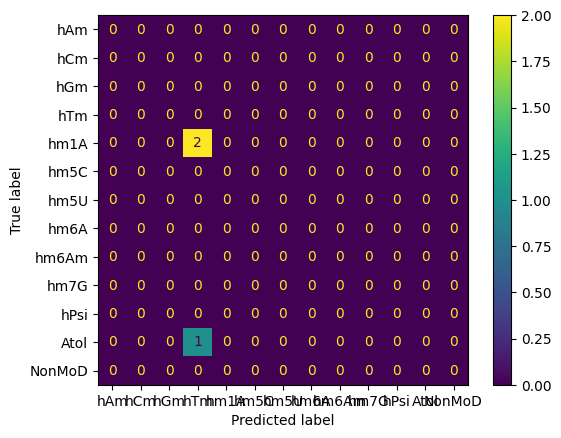

In [26]:
RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(np.array(RMs).reshape(-1, 1)) # adding reshape here

original_preds = []
original_labels = []

original_preds.extend(ohe.inverse_transform(one_hot_tensor.cpu().numpy()))  
original_labels.extend(ohe.inverse_transform(labels.cpu().numpy()))



cm = confusion_matrix(original_labels, original_preds, labels=RMs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=RMs)
disp.plot()

original_preds = np.array(original_preds).flatten()
original_labels = np.array(original_labels).flatten()

print(original_preds)
print(original_labels)


original_preds =['hm1A' 'hm1A' 'hGm']
original_labels  = ['hm1A' 'hm1A' 'hGm']

class_accuracies = [(np.array(original_preds)[np.array(original_labels) == i] == i).mean() for i in RMs]
for rm, acc in zip(RMs, class_accuracies):
    print(f"Accuracy for class {rm}: {acc}")

